<a href="https://colab.research.google.com/github/imran9891/TensorFlow/blob/main/09_Skimlit_NLP_Milestone_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: Skimlit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is availabel here: https://arxiv.org/abs/1612.05251

**Resource:** If we want to find the ground truth for this notebook (with lots of diagrams and text annotations) see the Github: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb


## Confirm access to GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-c1b66ec1-fb7e-7470-dcec-83f2258d17e6)


## Getting the data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the authords Github: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.


In [3]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


## Becoming one with the data

In [5]:
# Start our experiments using the 20k dataset with numbers replaced by the '@' sign
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

So, with that in mind, let's write a function to read in all of the lines of a target text file.

In [7]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filenames.
  """
  with open(filename, mode="r") as f:
    return f.readlines()

In [8]:
# Let's read in the training lines
train_lines= get_lines(filenames[0]) # read the lines within the training file
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

# Let's think about how we want our data to look...

How I think our data would be best represented...

```
[{'line_number':0,
   'target': 'BACKGROUND',
   'text': "Emotional eating is associated with overeating and the development of obesity .\n",
   'total_lines': 11},
   ...]
```

In [10]:
# Creating a function to convert text into dictionaries
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Args:
    filename: Takes in filename, reads it contents and sorts through each line,
    extracting things like the target label, the text of the sentence, how many
    sentences are in the current abstract and what sentence number the target
    line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the line is an ID line
      abstract_id = line 
      abstract_lines = "" # reset the abstract string if the line is an ID line
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines
    
      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line apper in the abstract
        line_data["total line"] = len(abstract_line_split)-1 # how many total lines are there in the target abstract?  (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [11]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(filenames[0])
val_samples = preprocess_text_with_line_numbers(filenames[1])
test_samples = preprocess_text_with_line_numbers(filenames[2])
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 551 ms, sys: 117 ms, total: 668 ms
Wall time: 667 ms


In [12]:
# Check the first abstract of the training data
train_samples[:20]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total line': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total line': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total line': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total line': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures included th

Now that our data is in the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it?

In [13]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [14]:
train_df.head(15)

,target,text,line_number,total line
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [15]:
# Check the distribution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

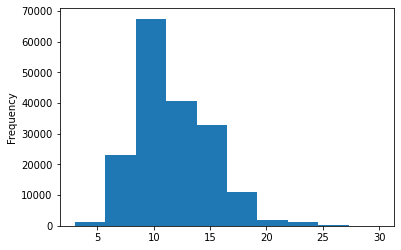

In [16]:
# Check the length of different lines
train_df["total line"].plot.hist();

## Get list of sentences

In [17]:
# Getting a list of sentences from Dataframes
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [18]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [19]:
# One hot encode labels for using Categorical Cross Entropy
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(X=train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(X=val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(X=test_df["target"].to_numpy().reshape(-1,1))

# Check what one hot encoded label look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [20]:
train_df["target"].to_numpy()

array(['OBJECTIVE', 'METHODS', 'METHODS', ..., 'RESULTS', 'CONCLUSIONS',
       'CONCLUSIONS'], dtype=object)

In [21]:
train_df["target"].to_numpy().reshape(-1,1)

array([['OBJECTIVE'],
       ['METHODS'],
       ['METHODS'],
       ...,
       ['RESULTS'],
       ['CONCLUSIONS'],
       ['CONCLUSIONS']], dtype=object)

## Label encode labels

In [22]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [23]:
# Get class names and number of classes from label encoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [24]:
# Get class names and number of classes from one hot encoder instance
nc = len(one_hot_encoder.categories_[0])
cn = one_hot_encoder.categories_
nc,cn

(5, [array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
        dtype=object)])

In [25]:
class_names == cn

array([[ True,  True,  True,  True,  True]])

## Starting a series of modelling experiments

As usual, we're going to be trying out a bunch of different models and seeing which one works best. And as always, we're going to start with a baseline (TF_IDF Multinomial Naive Bayes Classifier)

1. Model_0: Naive Bayes with TF-IDF encoder (baseline)
2. Model_1: Conv1D with token embeddings
3. Model_2: TensorFlow Hub Pretrained Feature Extractor
4. Model_3: Conv_1D with character embeddings
5. Model_4: Pretrained token embeddings (same as 2) + character embeddings (same as 3)
6. Model_5: Pretrained token embeddings + character embeddings + positional embeddings

## Model 0: Baseline model (Term Frequency — Inverse Document Frequency)

For more knowledge on TF-IDF see: https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tfidf",TfidfVectorizer()),
    ("clf",MultinomialNB())
])
model_0.fit(train_sentences,
            train_labels_encoded)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [27]:
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [28]:
# Make predictions with the baseline model
model_0_preds = model_0.predict(val_sentences)
model_0_preds

array([4, 1, 3, ..., 4, 4, 1])

In [29]:
# Check val labels
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [30]:
# Make predictions and return results using our baseline model
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true,y_pred):
  results = {}
  acc_score = accuracy_score(y_true,y_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,y_pred,average="weighted")
  results["accuracy"] = acc_score*100
  results["precision"] = model_precision
  results["recall"] = model_recall
  results["f1-score"] = model_f1
  return results

In [31]:
# Check baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=model_0_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1-score': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

## Tokenization

In [32]:
# How long is each sentence on an average?
import numpy as np
sent_lens = [len(sentence.split()) for sentence in train_sentences] # counts each word in separate lines
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

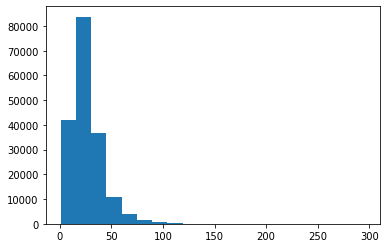

In [33]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=20);

In [34]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len # around 95% of the sentences are under 55 tokens in length

55

In [35]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers.

In [36]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
max_vocab_length = 68000 # taken from paper
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_sequence_length=output_seq_len,
                                    pad_to_max_tokens=True)

In [37]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [38]:
# Test out text vectorizer on random sentences
import random
random_sentence = random.choice(train_sentences)
print(f"Text:\n{random_sentence}\n\nLength of text: {len(random_sentence.split())} \n\nText Vectorizer output:\n {text_vectorizer([random_sentence])}")

Text:
genentech .

Length of text: 2 

Text Vectorizer output:
 [[12644     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [39]:
# How many words in vocabulary, most common words, most least common words?
words_in_vocab = text_vectorizer.get_vocabulary()
print(f"Total words in vocabulary: {len(words_in_vocab)}\n10 Most common words: {words_in_vocab[:10]}\n10 Most Least Common Words: {words_in_vocab[-10:]}")

Total words in vocabulary: 64841
10 Most common words: ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
10 Most Least Common Words: ['aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [40]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

### Create custom text embedding

In [41]:
# Create token embedding layer (feature-vector matrix representation)
from tensorflow.keras import layers
token_embed = layers.Embedding(input_dim=max_vocab_length, # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               mask_zero=True, # use masking to handle variable sequence length (save space)
                               input_length=output_seq_len,
                               name="token_embedding")

In [42]:
# Show example embedding
print(f"Sentence before vectorization:\n {random_sentence}\n")
vectorized_sentence = text_vectorizer([random_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedding_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedding_sentence}\n")
print(f"Embedded sentence shape: {embedding_sentence.shape}")

Sentence before vectorization:
 genentech .

Sentence after vectorization (before embedding):
 [[12644     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[-0.03463376 -0.01620088 -0.02343217 ... -0.01531476 -0.03951259
   -0.01163956]
  [-0.02700077  0.02049545 -0.01646866 ...  0.02615025 -0.02743224
    0.01419636]
  [-0.02700077  0.02049545 -0.01646866 ...  0.02615025 -0.02743224
    0.01419636]
  ...
  [-0.02700077  0.02049545 -0.01646866 ...  0.02615025 -0.02743224
    0.01419636]
  [-0.02700077  0.02049545 -0.01646866 ...  0.02615025 -0.02743224
    0.01419636]
  [-0.02700077  0.02049545 -0.01646866 ...  0.02615025 -0.02743224
    0.01419636]]]

Embedded sentence shape: (1,

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discusses at length in these two resources:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [43]:
# Turn our data into TensorFlow datasets (passing one_hot_encoded labels)
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [44]:
# Take the TensorSlice Datasets and turn them into prefetched datasets
train_dataset = train_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model_1: Conv1D with token embeddings

In [45]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype=tf.string,name='input_layer')
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  strides=1,
                  padding="same",
                  activation="relu") (x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation="softmax",name="output_layer")(x)
model_1 = tf.keras.Model(inputs,outputs,name='Conv1D')

In [46]:
model_1.summary()

Model: "Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8704000   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
output_layer (Dense)         (None, 5)                 325       
Total params: 8,745,349
Trainable params: 8,745,349
Non-trainable params: 0
__________________________________________________

In [47]:
# Compile the model
model_1.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [48]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(len(train_dataset)*0.1),
                              validation_data=valid_dataset,
                              validation_steps=int(len(valid_dataset)*0.1))

Epoch 1/3
562/562 [==============================] - 37s 14ms/step - loss: 0.9037 - accuracy: 0.6457 - val_loss: 0.6837 - val_accuracy: 0.7357
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6635 - accuracy: 0.7524 - val_loss: 0.6404 - val_accuracy: 0.7670
Epoch 3/3
562/562 [==============================] - 8s 13ms/step - loss: 0.6258 - accuracy: 0.7681 - val_loss: 0.6019 - val_accuracy: 0.7819


In [49]:
# Evaluate on whole valid dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.6058 - accuracy: 0.7821


[0.6058319211006165, 0.7820733189582825]

In [50]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs= model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.2639786e-01, 1.8657599e-01, 8.1832901e-02, 2.7901563e-01,
         2.6177652e-02],
        [4.8871705e-01, 2.7216190e-01, 1.2818152e-02, 2.1891277e-01,
         7.3902807e-03],
        [1.6338412e-01, 6.2021883e-03, 2.8063424e-03, 8.2757509e-01,
         3.2235534e-05],
        ...,
        [3.6979113e-06, 1.0558027e-03, 9.8011130e-04, 3.4085249e-06,
         9.9795699e-01],
        [4.7001991e-02, 5.1798826e-01, 7.2560735e-02, 5.7974838e-02,
         3.0447417e-01],
        [1.9951829e-01, 6.2089694e-01, 4.5551155e-02, 5.3284027e-02,
         8.0749564e-02]], dtype=float32), (30212, 5))

In [51]:
# Convert pred probs to classes
model_1_preds = model_1_pred_probs.argmax(axis=1)
model_1_preds

array([0, 0, 3, ..., 4, 1, 1])

In [52]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.20733483384086,
 'f1-score': 0.7795966224948089,
 'precision': 0.7785678586831211,
 'recall': 0.7820733483384086}

## Model 2: Feature Extraction with pretrained token embeddings

Now let's use pretrained word embeddings from TensorFlow Hub, more specifically the universal sentence encoder:
https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally use GloVe embeddings, however, we're going to stick with the later created `USE` pretrained embeddings.

### Model_2: USE (Universal Sentence Encoder)

In [53]:
import tensorflow_hub as hub
USE_URL = "https://tfhub.dev/google/universal-sentence-encoder/4"

In [54]:
# Download pretrained TensorFlow Hub USE
hub_embedding_layer = hub.KerasLayer(USE_URL,
                                     trainable=False,
                                     name="universal_sentence_encoder")

In [55]:
# Test out the pretrained embedding on a random sentence
random_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_sentence}\n")
use_embedding_sentence = hub_embedding_layer([random_sentence])
print(f"Sentence after embedding:\n {use_embedding_sentence}\n")
print(f"Shape of sentence embedding: {use_embedding_sentence.shape}")

Random sentence:
 there is a paucity of reports on the effects of lia on functional capability and quality of life .

Sentence after embedding:
 [[ 4.28144671e-02 -1.54402303e-02  2.27830391e-02  1.32070966e-02
   6.61118608e-03  3.00450809e-02 -4.26161960e-02  4.00601998e-02
  -3.98725783e-03  2.02434547e-02  3.70050669e-02  5.42537682e-02
   3.63755561e-02  9.79618803e-02  3.66396010e-02 -5.46394512e-02
  -4.79393639e-02  7.20659718e-02  1.46354188e-03  3.38633955e-02
   8.37596059e-02 -1.43369669e-02  4.76383679e-02  4.79945317e-02
   1.17568243e-02  3.80227715e-02  2.88032973e-03  6.38681650e-02
  -4.21610512e-02  5.66460975e-02  5.56122102e-02 -3.57527495e-03
  -1.64350644e-02 -6.31153733e-02 -7.08022192e-02 -2.24266760e-02
  -6.30831271e-02 -4.26837020e-02 -2.53521628e-03  3.99829671e-02
  -5.22715412e-02  4.58564423e-02 -6.43485459e-03  1.08193867e-02
   5.66352298e-03 -4.12754752e-02  3.66210900e-02  3.44533543e-03
   3.43619846e-02 -2.24897694e-02 -7.81381503e-02 -3.03646605e-

## Building and fitting an NLP feature extraction model using pretrained embeddings from TensorFlow Hub


In [56]:
inputs = layers.Input(shape=[],dtype=tf.string,name="input_layer")
pretrained_embedding = hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128,activation="relu")(pretrained_embedding)
# Note: we could add more layers if we wanted to
outputs = layers.Dense(num_classes,activation="softmax")(x)
model_2 = tf.keras.Model(inputs,outputs,name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [57]:
# Get the summary
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [58]:
# Fit the model
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 13s 18ms/step - loss: 0.9152 - accuracy: 0.6519 - val_loss: 0.7953 - val_accuracy: 0.6898
Epoch 2/3
562/562 [==============================] - 10s 18ms/step - loss: 0.7684 - accuracy: 0.7030 - val_loss: 0.7531 - val_accuracy: 0.7064
Epoch 3/3
562/562 [==============================] - 10s 17ms/step - loss: 0.7522 - accuracy: 0.7132 - val_loss: 0.7379 - val_accuracy: 0.7108


In [59]:
# Evaluate on the whole dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 14s 15ms/step - loss: 0.7411 - accuracy: 0.7136


[0.7411132454872131, 0.7135906219482422]

In [60]:
# Make predictions
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs, model_2_pred_probs.shape

(array([[4.1147950e-01, 3.6516097e-01, 2.8535966e-03, 2.1151282e-01,
         8.9931600e-03],
        [3.4751484e-01, 4.9235365e-01, 2.9398208e-03, 1.5411229e-01,
         3.0794370e-03],
        [2.1890311e-01, 1.2803510e-01, 1.7173560e-02, 5.9545064e-01,
         4.0437616e-02],
        ...,
        [1.8260496e-03, 6.0548829e-03, 5.8133926e-02, 8.4660202e-04,
         9.3313861e-01],
        [3.5808873e-03, 4.8112188e-02, 1.9788779e-01, 1.3947099e-03,
         7.4902445e-01],
        [1.6610600e-01, 2.7047777e-01, 4.9670374e-01, 5.1587061e-03,
         6.1553776e-02]], dtype=float32), (30212, 5))

In [61]:
# Convert pred_probs to classes
model_2_preds = model_2_pred_probs.argmax(axis=1)
model_2_preds

array([0, 1, 3, ..., 4, 4, 2])

In [62]:
# Getting the model 2 results
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.35906262412286,
 'f1-score': 0.7105437576408768,
 'precision': 0.7137814678309403,
 'recall': 0.7135906262412286}

## Model 3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings.

Previosuly, we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.



### Creating a character level tokenizer

In [63]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [78]:
" ".join(list(train_sentences[0]))

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [76]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_sentence)

't h e r e   i s   a   p a u c i t y   o f   r e p o r t s   o n   t h e   e f f e c t s   o f   l i a   o n   f u n c t i o n a l   c a p a b i l i t y   a n d   q u a l i t y   o f   l i f e   .'

In [80]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [89]:
# What's the average character length?
char_length = [len(sentence) for sentence in train_sentences] # counts lenght of all characters in a single sequence
avg_char_length = np.mean(char_length)
avg_char_length

149.3662574983337

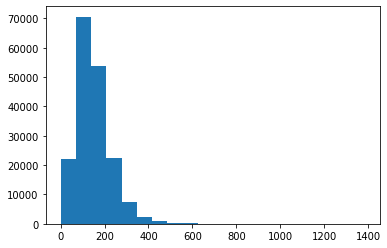

In [91]:
# Check the distribution of our sequences at a character-level
plt.hist(char_length,bins=20);

In [94]:
# What lenght of character covers 95% of sequences in character-level sequences
output_seq_char_len = int(np.percentile(char_length,95))
output_seq_char_len

290

In [95]:
# Get all keyboard characters
import string
aplhabet = string.ascii_lowercase + string.digits + string.punctuation
aplhabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [96]:
# Create char-level token vectorizer instance
NUM_CHARS_TOKENS = len(aplhabet) + 2 # add 2 for space and <OOV> token (out of vocab ='[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHARS_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    pad_to_max_tokens=True,
                                    name="char_vectorizer")

In [97]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [99]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 Most Common Characters: {char_vocab[:5]}")
print(f"5 Most Least Common Characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 Most Common Characters: ['', '[UNK]', 'e', 't', 'i']
5 Most Least Common Characters: ['k', 'x', 'z', 'q', 'j']


In [105]:
# Test our character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized text:\n {vectorized_chars}")
print(f"\nShape of Vectorized text: {vectorized_chars.shape}")

Charified text:
 d a t a   f r o m   a l l   s i t e s   w i l l   b e   m e r g e d   i n   o r d e r   t o   c o m p a r e   p r e v a l e n c e   a n d   a s s o c i a t i o n s   a c r o s s   s i t e s   o n   c o r e   v a r i a b l e s   .

Length of random_train_chars: 96

Vectorized text:
 [[10  5  3  5 17  8  7 15  5 12 12  9  4  3  2  9 20  4 12 12 22  2 15  2
   8 18  2 10  4  6  7  8 10  2  8  3  7 11  7 15 14  5  8  2 14  8  2 21
   5 12  2  6 11  2  5  6 10  5  9  9  7 11  4  5  3  4  7  6  9  5 11  8
   7  9  9  9  4  3  2  9  7  6 11  7  8  2 21  5  8  4  5 22 12  2  9  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0

## Character level embedding

In [122]:
from tensorflow.keras import layers
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different characters 
                              output_dim=25, # size of the char embedding in the paper
                              mask_zero=True,
                              name="char_embedding")

In [123]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization & embedding):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 d a t a   f r o m   a l l   s i t e s   w i l l   b e   m e r g e d   i n   o r d e r   t o   c o m p a r e   p r e v a l e n c e   a n d   a s s o c i a t i o n s   a c r o s s   s i t e s   o n   c o r e   v a r i a b l e s   .

Embedded chars (after vectorization & embedding):
 [[[-0.02154626 -0.03069183 -0.03996533 ...  0.04641395 -0.00824221
    0.02120986]
  [ 0.04155708  0.03157321 -0.03080451 ... -0.03304116 -0.01054901
   -0.01766057]
  [-0.00667077  0.03788072 -0.02249831 ...  0.01784178 -0.04753004
    0.01548048]
  ...
  [-0.04936956 -0.03845235 -0.01215938 ...  0.00391593  0.0005927
    0.04139607]
  [-0.04936956 -0.03845235 -0.01215938 ...  0.00391593  0.0005927
    0.04139607]
  [-0.04936956 -0.03845235 -0.01215938 ...  0.00391593  0.0005927
    0.04139607]]]

Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings

In [132]:
# Make Conv1D on chars only
inputs = layers.Input(shape=[],dtype=tf.string,name="input_layer")
x = char_vectorizer(inputs)
x = char_embed(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  strides=1,
                  padding="same",
                  activation="relu") (x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs,outputs,name="model_3_conv1D_char_emnbeddings")

# Compile
model_3.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [133]:
# Get the summary
model_3.summary()

Model: "model_3_conv1D_char_emnbeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None,)]                 0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embedding (Embedding)   (None, 290, 25)           700       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________

In [127]:
# Creating the character-level dataset
char_train_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
char_valid_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
char_test_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

char_train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [134]:
# Fit the model
history_model_3 = model_3.fit(char_train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(char_train_dataset)),
                              validation_data=char_valid_dataset,
                              validation_steps=int(0.1*len(char_valid_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 10ms/step - loss: 1.2486 - accuracy: 0.4871 - val_loss: 1.1146 - val_accuracy: 0.5436
Epoch 2/3
562/562 [==============================] - 5s 10ms/step - loss: 1.0721 - accuracy: 0.5639 - val_loss: 1.0013 - val_accuracy: 0.6014
Epoch 3/3
562/562 [==============================] - 5s 10ms/step - loss: 0.9784 - accuracy: 0.6121 - val_loss: 0.9233 - val_accuracy: 0.6403


In [135]:
# Evaluate on the whole dataset
model_3.evaluate(char_valid_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.9379 - accuracy: 0.6336


[0.9379128217697144, 0.6335561871528625]

In [136]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(char_valid_dataset)
model_3_pred_probs

array([[0.25594947, 0.33776882, 0.07896044, 0.30125248, 0.02606883],
       [0.15941238, 0.3503268 , 0.02619272, 0.4134187 , 0.05064944],
       [0.18446815, 0.18310061, 0.05628406, 0.5437891 , 0.0323581 ],
       ...,
       [0.01813489, 0.02520644, 0.14326318, 0.01599258, 0.79740286],
       [0.07870151, 0.14418669, 0.40374833, 0.12492998, 0.24843347],
       [0.43126372, 0.32624662, 0.10788536, 0.10533174, 0.02927248]],
      dtype=float32)

In [137]:
# Convert prediction probs to class labels
model_3_preds = model_3_pred_probs.argmax(axis=1)
model_3_preds

array([1, 3, 3, ..., 4, 2, 0])

In [139]:
# Model_3_results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 63.35562028333113,
 'f1-score': 0.623931942755814,
 'precision': 0.6386559766342752,
 'recall': 0.6335562028333113}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar to `model_2`)
2. Create a character-level embedding model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate layer (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [140]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu") (token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=[],dtype=tf.string,name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layer=layers.LSTM(units=24))(char_embeddings) # bi-LSTM as per paper
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout
combined_dropout = layers.Dropout(rate=0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(rate=0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input,char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [141]:
# Get the summary
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________

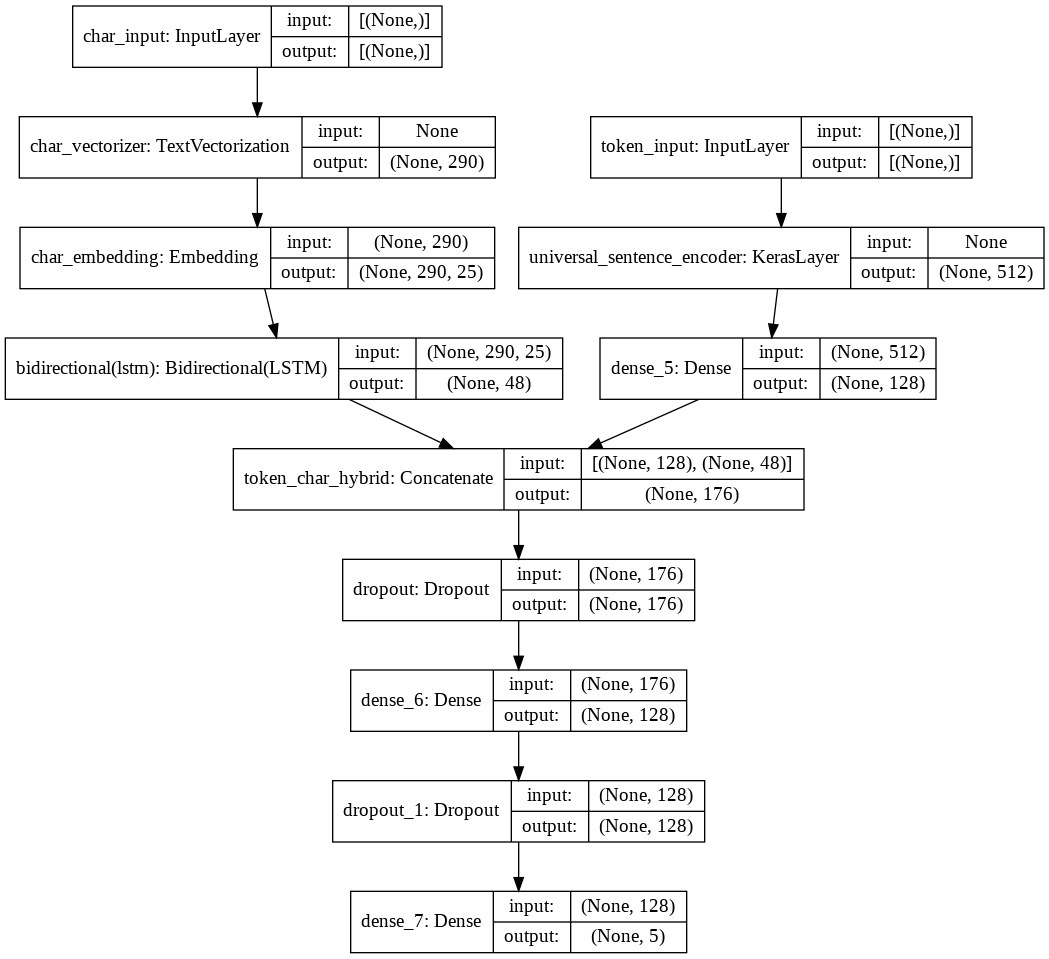

In [147]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4,show_shapes=True)

In [148]:
# Compile token char model
model_4.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

## Combining token and character data into a tf.data Datset

In [151]:
# 1. Combine chars and tokens into a Dataset for training data
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data,train_char_token_labels)) # combine data and labels
# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# 2. Combine chars and tokens into a Dataset for validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data,val_char_token_labels))
# Prefetch and batch validation data
val_char_token_dataset = val_char_token_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# 3. Combine chars and tokens into a Dataset for testing data
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences,test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data,test_char_token_labels))
# Prefetch and batch validation data
test_char_token_dataset = test_char_token_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [153]:
train_char_token_dataset, val_char_token_dataset, test_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)